In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
%%capture

from extractor import get_dataset

path = 'dataset/games.pgn'
num_games = 20000
device ='cuda'

white_X, black_X = get_dataset(path, num_games=num_games, device=device)
white_Y, black_Y = torch.ones((white_X.shape[0]), dtype=torch.float, device=device), torch.zeros((black_X.shape[0]), dtype=torch.float, device=device)

In [3]:
white_X.shape, black_X.shape

(torch.Size([70460, 773]), torch.Size([55290, 773]))

In [4]:
def view_matrix(x):
    img = torch.zeros((784))
    img[:x.shape[0]] = x.to(device).detach().clone()
    plt.imshow(img.view(28,28),cmap='gray')

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(773,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100)
        )

        self.decoder = nn.Sequential(
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,773),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)


In [6]:
ae_dataset = TensorDataset(torch.cat((white_X,black_X),dim=0),torch.cat((white_Y,black_Y),dim=0))
ae_loader = DataLoader(ae_dataset, batch_size=64, shuffle=True)

In [7]:
len(ae_dataset)

125750

In [8]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=0.1)

In [9]:
track = white_X[0].view(1,-1).detach()
track.shape

torch.Size([1, 773])

In [10]:
epochs = 20
outputs = []
losses = []

print_interval = len(ae_dataset)//(64*10)

for epoch in range(epochs):
    running_loss = 0
    print(f"Epoch {epoch+1}\n-------------------------------")
    for batch, (x, _) in enumerate(ae_loader):
        out = model(x)
        loss = criterion(out,x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch % print_interval == print_interval - 1:
            print(f'[{epoch + 1}, {batch + 1:5d}] loss: {running_loss / (print_interval):.3f}')
            running_loss = 0.0
    losses.append(running_loss)
    outputs.append(model(track))
print('finished_training')


Epoch 1
-------------------------------
[1,   196] loss: 0.250
[1,   392] loss: 0.248
[1,   588] loss: 0.246
[1,   784] loss: 0.244
[1,   980] loss: 0.241
[1,  1176] loss: 0.238
[1,  1372] loss: 0.235
[1,  1568] loss: 0.229
[1,  1764] loss: 0.220
[1,  1960] loss: 0.197
Epoch 2
-------------------------------
[2,   196] loss: 0.115
[2,   392] loss: 0.034
[2,   588] loss: 0.026
[2,   784] loss: 0.025
[2,   980] loss: 0.025
[2,  1176] loss: 0.024
[2,  1372] loss: 0.024
[2,  1568] loss: 0.024
[2,  1764] loss: 0.024
[2,  1960] loss: 0.024
Epoch 3
-------------------------------
[3,   196] loss: 0.024
[3,   392] loss: 0.024
[3,   588] loss: 0.024
[3,   784] loss: 0.024
[3,   980] loss: 0.024
[3,  1176] loss: 0.024
[3,  1372] loss: 0.024
[3,  1568] loss: 0.024
[3,  1764] loss: 0.024
[3,  1960] loss: 0.024
Epoch 4
-------------------------------
[4,   196] loss: 0.024
[4,   392] loss: 0.024
[4,   588] loss: 0.024
[4,   784] loss: 0.024
[4,   980] loss: 0.024
[4,  1176] loss: 0.024
[4,  1372] l

In [11]:
outputs[0].shape, track.shape

(torch.Size([1, 773]), torch.Size([1, 773]))

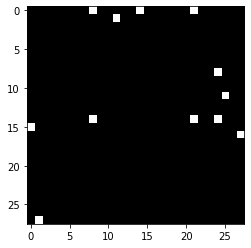

In [12]:
view_matrix(track[0])

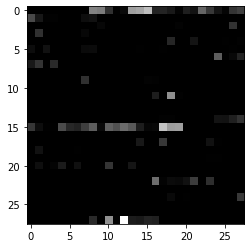

In [13]:
view_matrix(outputs[-1][0])

In [14]:
class DeepChess(nn.Module):
    def __init__(self):
        super().__init__()
        self.e = model.encoder
        self.fc1 = nn.Linear(200,100)
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,2)
    def forward(self, x1, x2):
        x1 = self.e(x1)
        x2 = self.e(x2)
        x = torch.cat((x1,x2),-1) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = DeepChess().to(device) 

In [15]:
#20% val 80 train

white_split = int(white_X.shape[0]*0.9)
black_split = int(black_X.shape[0]*0.9)

dataset_white_train = TensorDataset(white_X[:white_split,:],white_Y[:white_split])
dataset_black_train = TensorDataset(black_X[:black_split,:],black_Y[:black_split])
dataset_white_test = TensorDataset(white_X[white_split:,:],white_Y[white_split:])
dataset_black_test = TensorDataset(black_X[black_split:,:],black_Y[black_split:])

loader1 = DataLoader(dataset_white_train,batch_size=64,shuffle=True,drop_last=True)
loader2 = DataLoader(dataset_black_train,batch_size=64,shuffle=True,drop_last=True)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.1)

In [17]:
net.parameters

<bound method Module.parameters of DeepChess(
  (e): Sequential(
    (0): Linear(in_features=773, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)>

In [18]:
dataset_white_train.tensors[0].shape, dataset_black_train.tensors[0].shape 

(torch.Size([63414, 773]), torch.Size([49761, 773]))

In [19]:
len(loader1)

990

In [20]:
epochs = 200 #do 200 for tetsing 
losses = []

print_interval = len(ae_dataset)//(64*10)

for epoch in range(epochs):
    running_loss = 0
    for batch, (data1, data2) in enumerate(zip(loader1,loader2)):
        
        x1, y1 = data1
        x2, y2 = data2

        pred = net(x1,x2)
        
        target = torch.stack((y1,y2),dim=1)
        loss = criterion(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if batch % print_interval == print_interval - 1:
            print(f'[{epoch + 1}, {batch + 1:5d}] loss: {running_loss / (print_interval):.3f}')
            running_loss = 0.0
    
    losses.append(running_loss)

print('finished_training')


[1,   196] loss: 0.010
[1,   392] loss: 0.000
[1,   588] loss: 0.000
[2,   196] loss: 0.000
[2,   392] loss: 0.000
[2,   588] loss: 0.000
[3,   196] loss: 0.000
[3,   392] loss: 0.000
[3,   588] loss: 0.000
[4,   196] loss: 0.000
[4,   392] loss: 0.000
[4,   588] loss: 0.000
[5,   196] loss: 0.000
[5,   392] loss: 0.000
[5,   588] loss: 0.000
[6,   196] loss: 0.000
[6,   392] loss: 0.000
[6,   588] loss: 0.000
[7,   196] loss: 0.000
[7,   392] loss: 0.000
[7,   588] loss: 0.000
[8,   196] loss: 0.000
[8,   392] loss: 0.000
[8,   588] loss: 0.000
[9,   196] loss: 0.000
[9,   392] loss: 0.000
[9,   588] loss: 0.000
[10,   196] loss: 0.000
[10,   392] loss: 0.000
[10,   588] loss: 0.000
[11,   196] loss: 0.000
[11,   392] loss: 0.000
[11,   588] loss: 0.000
[12,   196] loss: 0.000
[12,   392] loss: 0.000
[12,   588] loss: 0.000
[13,   196] loss: 0.000
[13,   392] loss: 0.000
[13,   588] loss: 0.000
[14,   196] loss: 0.000
[14,   392] loss: 0.000
[14,   588] loss: 0.000
[15,   196] loss: 0

In [21]:
import os
duration = 1  # seconds
freq = 120  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

0

In [23]:
#test 
train_loader1 = DataLoader(dataset_white_test,shuffle=True,batch_size=1)
train_loader2 = DataLoader(dataset_black_test,shuffle=True,batch_size=1)

In [41]:
acc = 0
count = 0
with torch.no_grad():
    for data1, data2 in zip(train_loader1, train_loader2):
        x1, y1 = data1
        x2, y2 = data2
        #pred = nn.functional.softmax(net(x1,x2),dim=-1)
        pred = net(x1,x2)
        y = torch.stack((y1,y2),dim=1)
        print(y)
        print(torch.sum(torch.argmax(pred) == torch.argmax(y)).data)
        count += 1

tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='cuda:0')
tensor([[1., 0.]], device='cuda:0')
tensor(1, device='c

In [ ]:
plt.plot(losses)